# >>> Project

2 7 5 1 8 6 4 3 9 
6 9 4 7 5 3 2 1 8 
1 8 3 4 9 2 5 6 7 
9 4 1 3 2 7 6 8 5 
3 2 8 5 6 9 7 4 1 
5 6 7 8 1 4 9 2 3 
4 1 6 9 3 5 8 7 2 
7 3 9 2 4 8 1 5 6 
8 5 2 6 7 1 3 9 4 
[[2, 7, 5, 1, 8, 6, 4, 3, 9], [6, 9, 4, 7, 5, 3, 2, 1, 8], [1, 8, 3, 4, 9, 2, 5, 6, 7], [9, 4, 1, 3, 2, 7, 6, 8, 5], [3, 2, 8, 5, 6, 9, 7, 4, 1], [5, 6, 7, 8, 1, 4, 9, 2, 3], [4, 1, 6, 9, 3, 5, 8, 7, 2], [7, 3, 9, 2, 4, 8, 1, 5, 6], [8, 5, 2, 6, 7, 1, 3, 9, 4]]
[[2, 0, 0, 1, 8, 0, 0, 3, 0], [6, 0, 4, 0, 0, 0, 2, 0, 0], [1, 0, 0, 4, 9, 0, 0, 0, 7], [0, 0, 1, 3, 0, 7, 0, 0, 0], [0, 2, 0, 0, 6, 0, 0, 4, 0], [0, 0, 0, 8, 0, 4, 9, 0, 0], [4, 0, 0, 0, 3, 5, 0, 0, 2], [0, 0, 9, 0, 0, 0, 1, 0, 6], [0, 5, 0, 0, 7, 1, 0, 0, 4]]


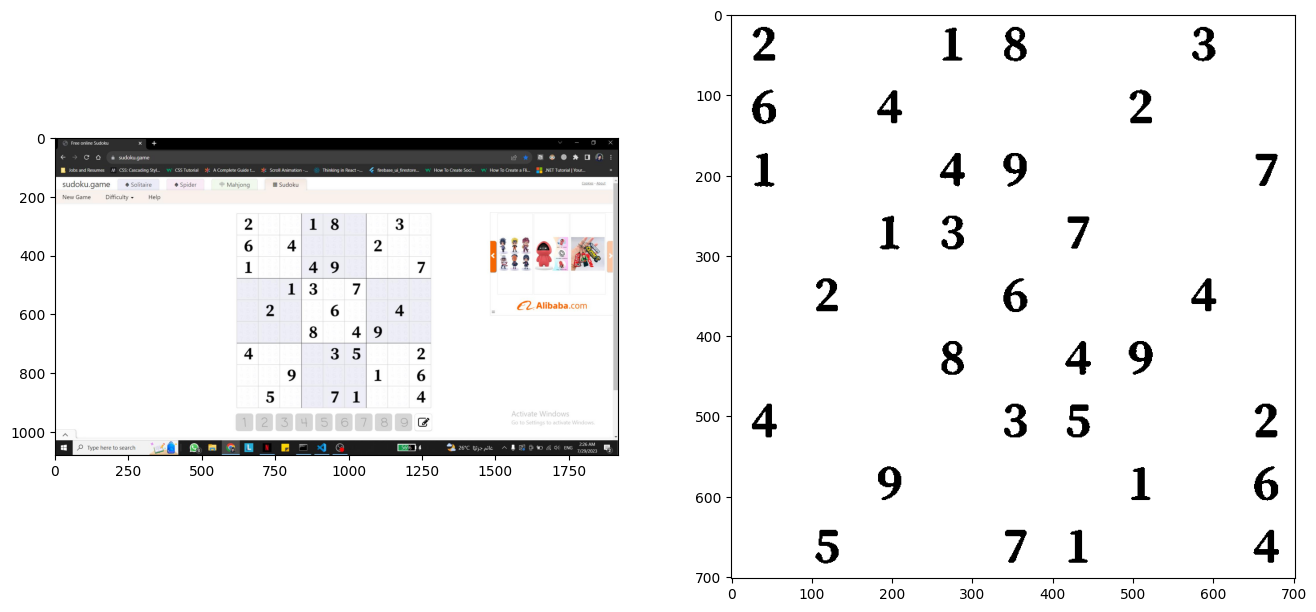

In [4]:
import pyautogui
import keyboard
from pytesseract import *
import argparse
from pynput import mouse

from matplotlib.pyplot import imshow, show, subplot, title, get_cmap, imsave
from skimage.color import rgb2gray, gray2rgb, rgb2hsv, rgb2lab, lab2rgb
from skimage.filters.rank import median
from skimage import data, io, exposure, filters
from skimage.morphology import disk
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
from skimage.morphology import erosion, dilation, opening, closing, disk

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))

screenImage = imread("PIC_original.jpg")

def ScreenShot():
    global screenImage
    
    myScreenshot = pyautogui.screenshot()
    myScreenshot.save(r'PIC_original.jpg')

    img = imread("PIC_original.jpg")

    ax1.imshow(img)

yBoundries = [0, 702]
xBoundries = [0, 702]

resizingResolution = [0, 702]

def on_click(x, y, button, pressed):
    global yBoundries
    global xBoundries

    if yBoundries[0] == 0 and xBoundries[0] == 0:
        xBoundries[0] = x
        yBoundries[0] = y
    else:
        xBoundries[1] = x
        yBoundries[1] = y

    if not pressed:
        return False

def TakeBoundries():
    with mouse.Listener(on_click=on_click) as listener:
        listener.join()
    with mouse.Listener(on_click=on_click) as listener:
        listener.join()

def imageCleaning():
    global screenImage
    global yBoundries
    global xBoundries

    screenImage = imread("PIC_original.jpg")
    screenImage = rgb2gray(screenImage)
    screenImage = screenImage[yBoundries[0]:yBoundries[1], xBoundries[0]:xBoundries[1]]

    screenImage = resize(screenImage, (resizingResolution[1], resizingResolution[1]), anti_aliasing=True)

    ######## removing noise #######
    threshold = 0.18
    def removeThres(pixel):
        if pixel > threshold:
            return 1
        return 0
    
    # range of sudoku image only
    for i in range(resizingResolution[0], resizingResolution[1]):
        screenImage[i] = [removeThres(p) for p in screenImage[i]]
    ###############################

    screenImage = erosion(screenImage, disk(1))

    # start square center position is (637, 253) and every square's width and height is 78 pixel
    # so, to manually derive numbers data we have to loop from 598 to 676 and 214 to 292 with every
    # number in this square or looping in every number position
    #### do not run this part #### 
    # numberList = []
    # number = []
    # for i in range(214, 292):
    #     for j in range(598, 676):
    #         if screenImage[i+2][j+2] == 1 or screenImage[i-2][j-2] == 1 or screenImage[i+2][j-2] == 1 or screenImage[i-2][j+2] == 1 or screenImage[i-2][j] == 1 or screenImage[i+2][j] == 1 or screenImage[i][j-2] == 1 or screenImage[i][j+2] == 1:
    #             numberList.append(1.0)
    #         else:
    #             numberList.append(screenImage[i][j])
    #     number.append(numberList)
    #     numberList = []

    # with open('numbersDATA.txt', 'a') as file:
    #     file.write('9:\n')
    #     for List in number:
    #         for pixel in List:
    #             file.write(f"{pixel},")
    #         file.write("\n")
    #     file.write("\n")
    ##############################


    imsave('PIC_proccessed.jpg', screenImage)
    ax2.imshow(screenImage, cmap='gray')


numbersData = []
lineData = []

def readNumbersData():
    global lineData
    global numbersData

    with open('numbersDATA.txt') as file:
        while True:
            line = file.readline()
            if not line:
                break
            # if len > 5 then it's not the number indicator line it's data line
            if len(line) > 5:
                linelist = line.strip().split(',')
                linelist.remove('')
                lineData.append(np.float_(linelist))
            elif lineData:
                numbersData.append(lineData)
                lineData = []

boardNums = []
tempboardNums = []

def getBlocksData():
    global xBoundries
    global yBoundries
    global numbersData
    global boardNums
    global tempboardNums

    LineNums = []

    # check the first block number
    for k in range(9):
        for m in range(9):

            numDetect = [True, True, True, True, True, True, True, True, True]
            zeroCounter = 0
            oneCounter = 0

            xCellBoundries = (0+(k*78), 78+(k*78))
            yCellBoundries = (0+(m*78), 78+(m*78))

            for i in range(xCellBoundries[0], xCellBoundries[1]):
                for j in range(yCellBoundries[0], yCellBoundries[1]):
                    for index in range(9):
                        if screenImage[i][j] != numbersData[index][i-(xCellBoundries[0])][j-(yCellBoundries[0])] and numbersData[index][i-(xCellBoundries[0])][j-(yCellBoundries[0])] == 0:
                            numDetect[index] = False

                    if screenImage[i][j] == 0:
                        zeroCounter += 1
            
            if numDetect.count(True) > 1:
                numDetect[2] = False

            if True in numDetect:
                LineNums.append(numDetect.index(True)+1)
            else:
                LineNums.append(0)

        boardNums.append(LineNums)
        LineNums = []

    tempboardNums = str(boardNums)

def Solve():
    global boardNums

    M = 9

    def puzzle(a):
        for i in range(M):
            for j in range(M):
                print(a[i][j],end = " ")
            print()

    def solve(grid, row, col, num):
        for x in range(9):
            if grid[row][x] == num:
                return False
                
        for x in range(9):
            if grid[x][col] == num:
                return False
    
        startRow = row - row % 3
        startCol = col - col % 3
        for i in range(3):
            for j in range(3):
                if grid[i + startRow][j + startCol] == num:
                    return False
        return True
 
    def Suduko(grid, row, col):
    
        if (row == M - 1 and col == M):
            return True
        if col == M:
            row += 1
            col = 0
        if grid[row][col] > 0:
            return Suduko(grid, row, col + 1)
        for num in range(1, M + 1, 1): 
        
            if solve(grid, row, col, num):
            
                grid[row][col] = num
                if Suduko(grid, row, col + 1):
                    return True
            grid[row][col] = 0
        return False
    
    if (Suduko(boardNums, 0, 0)):
        puzzle(boardNums)
    else:
        print("cannot solve")

def readyAutoGUI():
    global boardNums
    global tempboardNums

    import json

    tempboardNums = json.loads(tempboardNums)

    print(boardNums)
    print(tempboardNums)

    additionX = ((xBoundries[1]-xBoundries[0])/9)
    additionY = ((yBoundries[1]-yBoundries[0])/9)

    for k in range(9):
        for m in range(9):

            if tempboardNums[k][m] != 0:
                continue

            pyautogui.click(xBoundries[0]+(m*additionX) + (additionX/2), yBoundries[0]+(k*additionY) + (additionY/2))

            pyautogui.press(str(boardNums[k][m]))


while True:
    if keyboard.read_key() == "s":
        ScreenShot()
        TakeBoundries()
        imageCleaning()
        readNumbersData()
        getBlocksData()
        Solve()
        readyAutoGUI()
        break
